In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import os,sys
import random
from skimage.transform import resize
import models
sys.path.insert(0,'/home/huangz78/hydro/unet3d/')
from models.unet3d_model import UNet3D
from models.dnet import weights_init,Discriminator
from models.utils import illustrate, visualization
from train import gan_train,noise_generate
from importlib import reload

manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [21]:
reload(models.utils)
from models.utils import illustrate, visualization

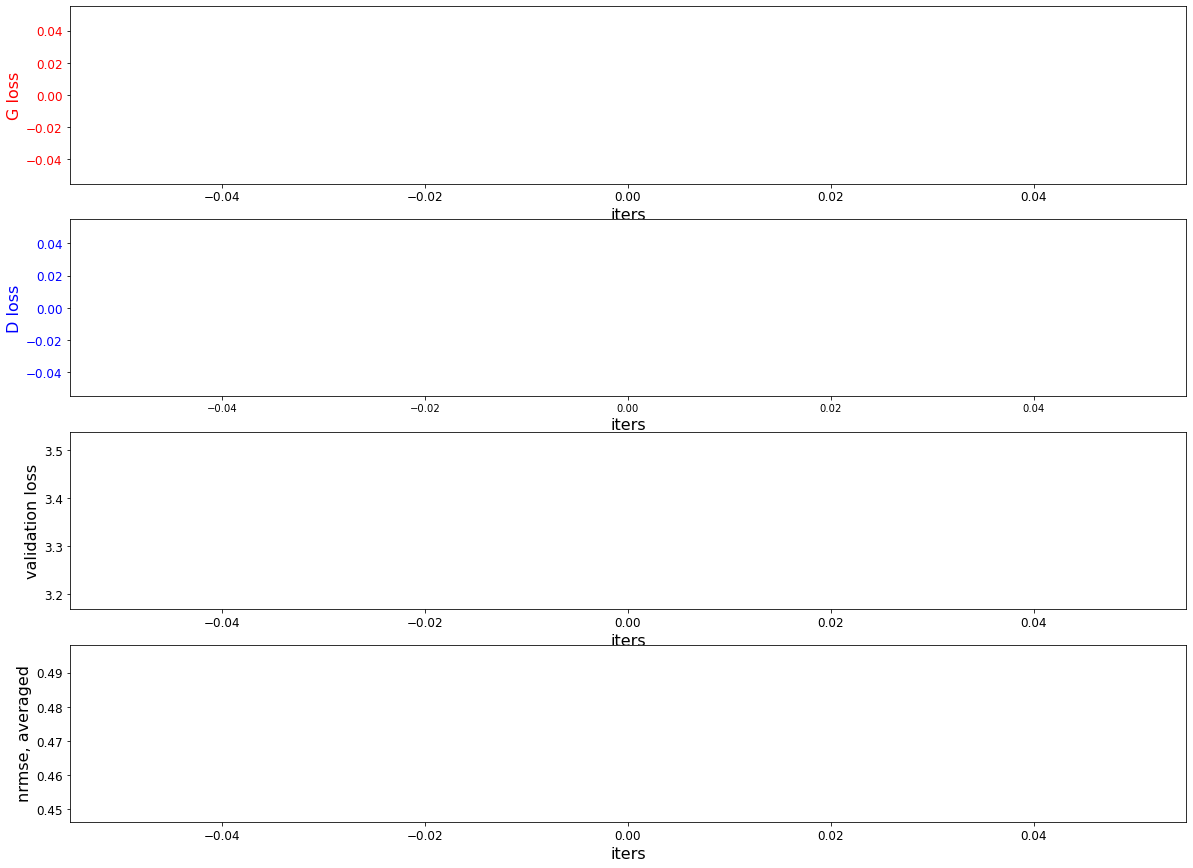

In [22]:
errorRec_path = '/home/huangz78/checkpoints/gan_train_track.npz'
errordata = np.load(errorRec_path)
%matplotlib inline
visualization(errordata['g_loss'],errordata['d_loss'],errordata['val_loss'],errordata['nrmse'],log1=False,log2=False,window=5)

Total amount of files: 13798


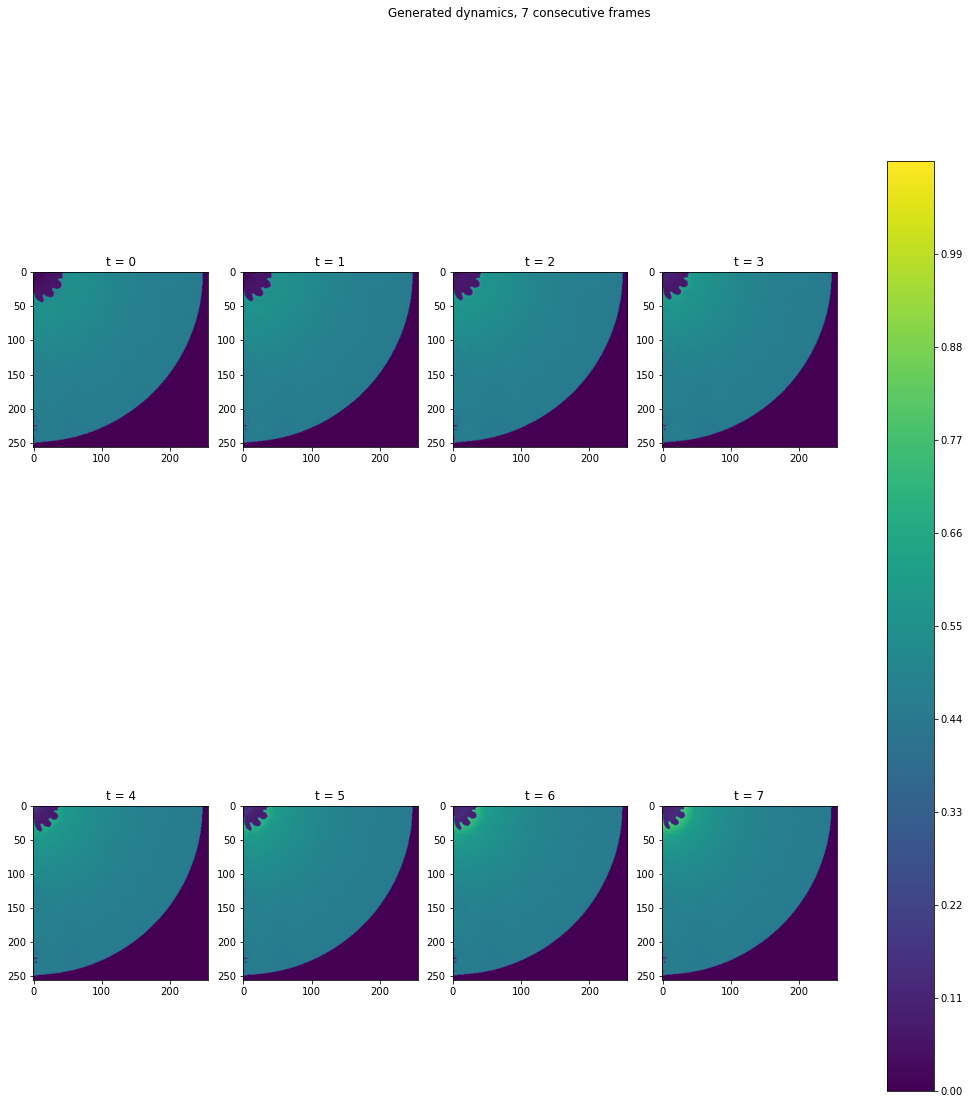

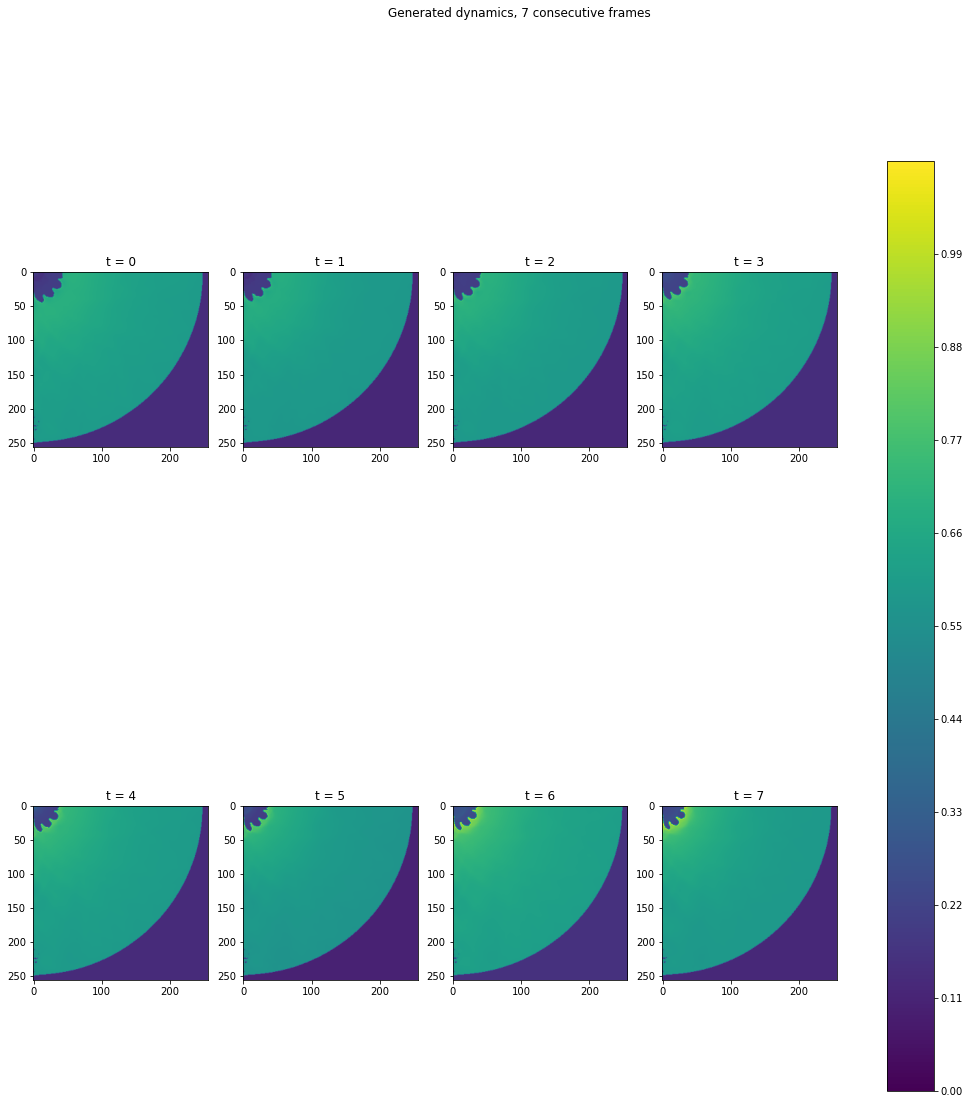

In [24]:
datapath = '/mnt/shared_b/data/hydro_simulations/data/'
ncfiles = list([])
for file in os.listdir(datapath):
    if file.endswith(".nc"):
        ncfiles.append(file)
print('Total amount of files:', len(ncfiles))
img_size = 320
dep = 8
fileexp_ind = 8700
# val = []
# for fileexp_ind in range(len(ncfiles)):
filename = ncfiles[fileexp_ind]
sim = xr.open_dataarray(datapath+filename)
# val.append(np.max(np.array(sim)[:dep,:,:].flatten()))
sim.close()
dyn   = np.zeros((1,1,dep,256,256))            # load one sample, show it
noise = np.zeros((1,1,dep,256,256))    # make a noise sample, add it to the ground truth, show it
for t in range(dep):
    dyn[0,0,t,:,:] = resize(sim.isel(t=t)[:img_size,:img_size].values,(256,256),anti_aliasing=True)
normalize_factor   = np.max( np.abs(dyn[0,0,:,:,:]).flatten() )
dyn[0,0,:,:,:]  = dyn[0,0,:,:,:] / normalize_factor
for t in range(dep): # different noise for each frame when using a 'for' loop
    noise[0,0,t,:,:] = noise_generate(dyn[0,0,t,:,:],mode='linear') 
dyn = torch.tensor(dyn).to(torch.float); noise = torch.tensor(noise).to(torch.float)

%matplotlib inline
illustrate(dyn)
illustrate(noise + dyn)

G net loaded from /home/huangz78/checkpoints/netG.pth


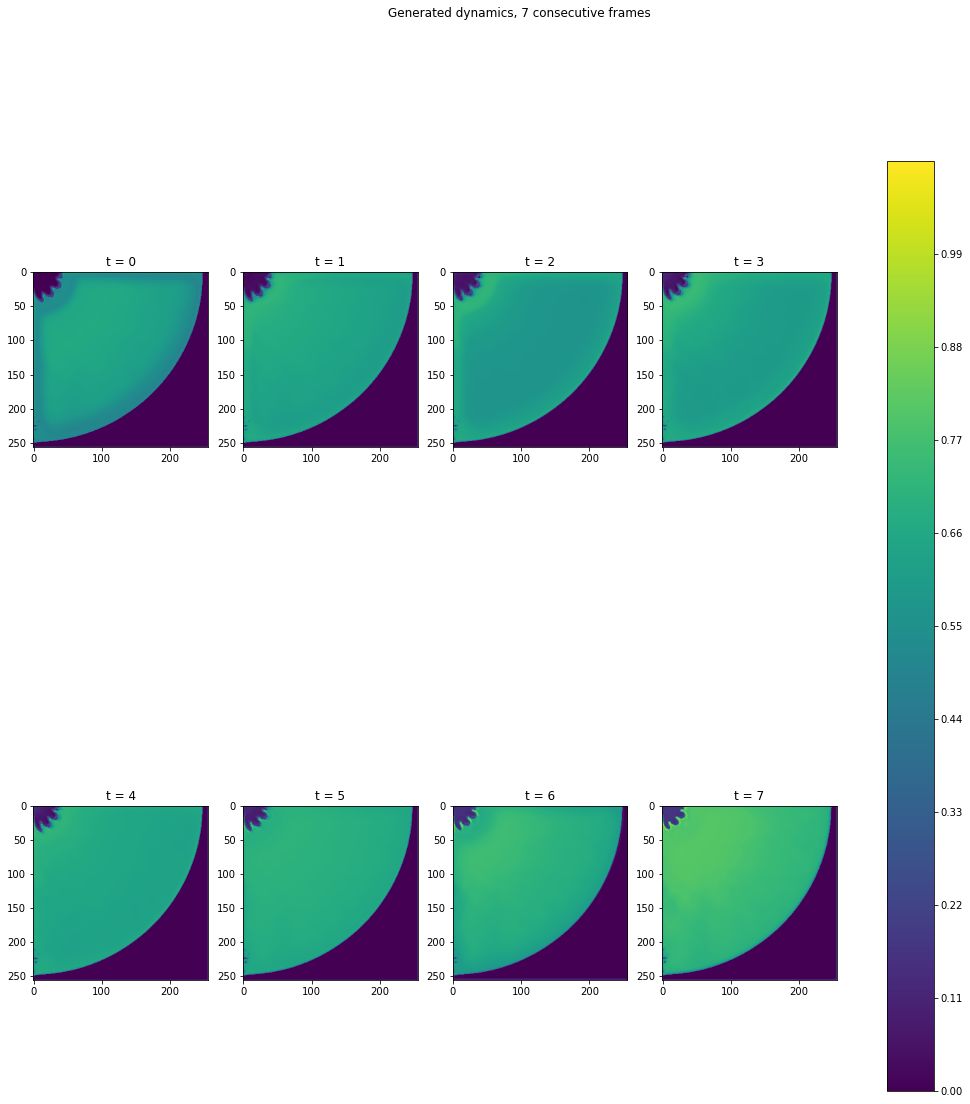

In [25]:
# load a G net
gnet = UNet3D(1,1,is_segmentation=False,final_sigmoid=False)
gpath = '/home/huangz78/checkpoints/netG.pth'
checkpoint = torch.load(gpath)
gnet.load_state_dict(checkpoint['model_state_dict'])
print(f'G net loaded from {gpath}')

# apply denoiser, show the outcome
noisy_dyn     = noise + dyn
denoised_samp = gnet(noisy_dyn)
illustrate(denoised_samp)